In [1]:
import Bio
from Bio import SeqIO
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import random
from six.moves import cPickle as pickle
import xgboost as xgb
from Bio.SeqIO.FastaIO import SimpleFastaParser
import gc


# data_root = "C:\\Users\\Tigran PC\\Desktop\\MicrobiomicsData\\data\\" # notebook
# data_root = "/Users/tigran/Desktop/sbv/data/" # imac
data_root = "C:\\Users\\Administrator\\Repos\\Microbiomics\\data\\" # server

sub_data_root = data_root + "sample01split/"

In [2]:
def make_features(seq, sub_seq_bank, lable):
    sub_seq_count = []
    for sub_seq in sub_seq_bank:
        sub_seq_count.append(seq.count(sub_seq))
#         sub_seq_count.append(my_count(seq, sub_seq))
    sub_seq_count.append(lable)
    return sub_seq_count


def make_sub_seq_bank(initial_string, sub_seq_len):
    return [''.join(tup) for tup in  list(set(product(set(initial_string), repeat = sub_seq_len)))]

def my_count(string, substring):
    string_size = len(string)
    substring_size = len(substring)
    count = 0
    for i in xrange(0,string_size-substring_size+1):
        if string[i:i+substring_size] == substring:
            count+=1
    return count
            
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def convert_read_to_numb(dataframe, sub_str_len):
    ss_bank = make_sub_seq_bank("ATCG", sub_str_len)
    data_list = []
    for i, val in enumerate(dataframe.values):        
        tmp_counts = make_features(val[0], ss_bank, val[1])
        data_list.append(tmp_counts)
    return pd.DataFrame(data_list, columns=ss_bank.append("lable"))
    gc.collect()

def make_data_frame(features, lable):
    df = pd.DataFrame(features)
    df['lable'] = lable    
    return df
    


In [3]:
df1 = pd.read_pickle(data_root + "DNA_data1.pickle")

In [4]:
df2 = pd.read_pickle(data_root + "DNA_data2.pickle")

In [5]:
print(df1.shape)
print(df2.shape)
df = pd.concat([df1, df2]) 

df.head()

(39341870, 2)
(39389753, 2)


,0,lable
0,TTACGACACCTGGTCGACGGTGTACAACCAGCTCGAGGGCACTTGG...,1768
1,GAACGGCCGCAGCTCGTCGATCACCCCGGTCAGCGCCCGCGTCTCC...,1751294
2,AGCCTATATTAAATTGCTACCGCCTGAAAAACGAGGAGCGGAGAAC...,189834
3,TGGTATTTCTCTGTATCAAAATTGGCGTTTTGATAATAATACGGGA...,1954172
4,GTAAAGGTCAGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...,741091


In [6]:
df.shape

(78731623, 2)

In [7]:
with open(data_root + 'taxid.txt') as f:
    keys = f.readlines()
keys = [x.strip() for x in keys] 

In [24]:
some_values = keys[10:20]
df1 = df.loc[df['lable'].isin(some_values)]

In [25]:
df1.head(10)

,0,lable
189,GCCCGGATCGACGACGCCGTGAGCGCACCGACCGCCAGGACCGATG...,103816
255,TGCCGAATATCCCGGCCGGGTGATGCTGGCGGAGGCGAACCAGTGG...,103816
284,GACATATCCCTGTGGGTCCGGATGAATCAGGATTTCCACGCCGGGA...,1030157
593,TGGAACACCTGGCCGGCCGGGATGATGTGCATTGCGTGGGGCTGTC...,103855
1148,CGTCGTAGCCGATGGGCGAGTCGACCGTCAGGCCGGAACCCGCGGT...,103855
1332,GCCGTCGGCCACGAGGAAGGCCGCGCCGCGAAACGACATCAGCCCG...,1034889
1353,CGGCTACGGAAGTTGGAGTGTGCGGATGGGTTCAGGCGTGGCACGC...,1033922
1629,GCTAGCGAAGACTGCGGCACATTCGCAGCAGATGCCGTGACTTTAC...,1028989
2005,GCTGAGCTGCGCAGCCCAGGCACCGGCGGCGTTGATCAAGGTGTCG...,104087
2134,GGCTATCGGTTCTTTGCCGACCTGCTGGACCTGGCCCGTAACAGCG...,1028989


### Convert to numbers

In [26]:
gc.collect()
df1.shape

(396604, 2)

In [27]:
%time df1 =  convert_read_to_numb(df1, 4) 

Wall time: 2min 30s


In [28]:
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0,0,0,0,2,0,0,0,0,0,...,1,0,5,2,2,3,1,0,2,103816
1,1,0,0,0,1,0,0,0,0,1,...,1,0,1,4,0,0,2,0,1,103816
2,1,0,0,2,0,1,3,0,0,0,...,1,1,1,3,1,1,2,0,1,1030157
3,0,0,0,1,2,0,2,0,0,0,...,1,1,2,2,1,5,2,0,0,103855
4,1,0,1,2,5,0,0,0,0,1,...,1,0,3,5,0,1,3,0,3,103855
5,3,0,0,1,1,0,1,0,1,0,...,3,0,1,4,1,6,0,0,0,1034889
6,0,1,0,1,1,0,0,0,0,0,...,0,2,1,4,2,3,1,0,3,1033922
7,1,2,1,1,0,1,0,1,0,2,...,1,1,0,5,1,1,1,1,1,1028989
8,1,0,0,1,2,0,1,1,1,0,...,1,1,1,3,0,2,0,0,1,104087
9,0,1,0,0,0,0,2,1,0,0,...,0,0,0,1,1,1,1,0,0,1028989


In [29]:
columns = list(df1.columns.values)
print(type(columns))
df1 = df1.sample(frac=1).reset_index(drop=True)
print(df1.shape)
df1 = df1.drop_duplicates(subset=columns[:-1])
print(df1.shape)

# df.to_csv(data_root + "DNA_data.csv")


# df.head(20)

<class 'list'>
(396604, 257)
(396591, 257)


In [30]:
# # df2 = df1[np.abs(df1.values[:, :-1]-df1.values[:, :-1].mean())<=(3*df1.values[:, :-1].std())]
# from scipy import stats
# df2 = df1[(np.abs(stats.zscore(df1.iloc[:,:-1])) < 5).all(axis=1)]

# print(df2.shape)

In [31]:
X = df1.values[:, :-1]
y = df1.values[:, -1]

In [32]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [33]:
# pickle_file = data_root + "DNA_data.pickle"

# try:   
#     f = open(pickle_file, 'wb')
#     pickle.dump(df1, f, pickle.HIGHEST_PROTOCOL)
#     f.close()
# except Exception as e:
#     print('Unable to save data to', pickle_file, ':', e)
#     raise

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [43]:
%time gbm = xgb.XGBClassifier(max_depth=5, n_estimators=250, learning_rate=0.8, n_jobs=-1, colsample_bytree=0.8, colsample_bylevel=0.8).fit(x_train, y_train)
print("done")

# param = {
#  "n_estimators":[50,100,150,200], 250
#  "max_depth":[2,3,4,5,6,7,8,9],
#  "min_child_weight":[2,3,4,5],
#  "colsample_bytree":[0.2,0.6,0.8],
#  "colsample_bylevel":[0.2,0.6,0.8]
# }

Wall time: 5min 41s
done


In [47]:
%time y_pred = gbm.predict(x_test)
print("done")

Wall time: 1.61 s
done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
accuracy_score(y_test, y_pred)

0.6587702820257442

Normalized confusion matrix
[[8.13746288e-01 1.24734832e-01 2.12134069e-03 0.00000000e+00
  4.24268137e-04 8.48536275e-04 0.00000000e+00 8.48536275e-04
  3.73355961e-02 1.99406025e-02]
 [5.59345157e-02 8.75170532e-01 1.00045475e-02 6.82128240e-04
  0.00000000e+00 6.82128240e-04 0.00000000e+00 1.13688040e-03
  2.22828558e-02 3.41064120e-02]
 [1.77346891e-03 8.74911327e-03 3.98675810e-01 1.97446205e-02
  4.61101915e-03 3.53511468e-02 7.21210688e-03 7.41310002e-02
  1.25325136e-02 4.37219201e-01]
 [5.51571980e-04 1.10314396e-03 2.13274499e-02 6.09670895e-01
  9.19286634e-03 8.47582276e-02 1.41570142e-02 1.07740393e-01
  2.50045964e-02 1.26493841e-01]
 [0.00000000e+00 0.00000000e+00 4.41787942e-03 7.53638254e-03
  6.39812890e-01 7.49740125e-02 2.32848233e-01 1.98804574e-02
  6.49688150e-04 1.98804574e-02]
 [9.87166831e-05 6.91016782e-04 2.13228036e-02 3.22803554e-02
  5.24185587e-02 6.21125370e-01 4.24481737e-02 1.20631787e-01
  8.19348470e-03 1.00789733e-01]
 [0.00000000e+00 0.00000000e+0

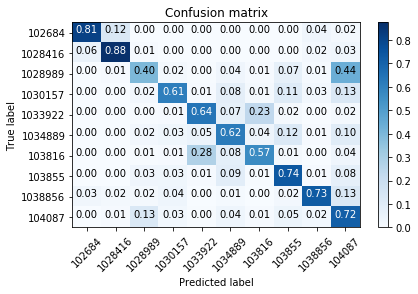

In [49]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), some_values, normalize=True)

### RandomForestClassifier

In [50]:
clf = RandomForestClassifier(**{'bootstrap': True,
                             'max_depth': 100,
                             'max_features': 3,
                             'min_samples_leaf': 2,
                             'min_samples_split': 4,
                             'n_estimators': 100
                               "n_jobs": -1})


In [51]:
%time clf.fit(x_train, y_train)

Wall time: 24.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
%time y_pred = clf.predict(x_test)

Wall time: 1.9 s


In [53]:
accuracy_score(y_test, y_pred)

0.8104618440655521

In [54]:
confusion_matrix(y_test, y_pred)

array([[ 7018,   421,  2839],
       [ 1015,  5425,   519],
       [  861,    70, 12037]], dtype=int64)

Normalized confusion matrix
[[0.68281767 0.04096128 0.27622105]
 [0.14585429 0.77956603 0.07457968]
 [0.0663942  0.0053979  0.9282079 ]]


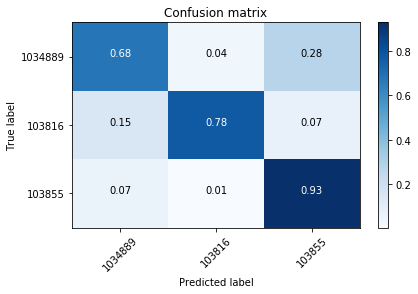

In [55]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), some_values, normalize=True)

# GridSearch

In [56]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
# Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [2, 3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

param = {
 "n_estimators":[50,100,150,200],
 "max_depth":[2,3,4,5,6,7,8,9],
 "min_child_weight":[2,3,4,5],
 "colsample_bytree":[0.2,0.6,0.8],
 "colsample_bylevel":[0.2,0.6,0.8]
}


grid_search = GridSearchCV(estimator = xgb.XGBClassifier( objective="reg:linear", seed=1, n_jobs=-1), param_grid = param, 
    scoring="mean_absolute_error",
    cv=10,
    verbose = 1, n_jobs = -1)


# Create a based model
# rf = RandomForestClassifier()
gbm = xgb.XGBClassifier
# Instantiate the grid search model
# grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
%time  grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


In [38]:
best_grid = grid_search.best_estimator_

In [39]:
%time y_pred = best_grid.predict(x_test)

Wall time: 347 ms


In [40]:
accuracy_score(y_test, y_pred)

0.8787909941400226

In [ ]:
confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[3.14094775e-01 1.21506683e-03 6.84690158e-01]
 [0.00000000e+00 9.99814195e-01 1.85804534e-04]
 [1.40792886e-02 4.07558355e-03 9.81845128e-01]]


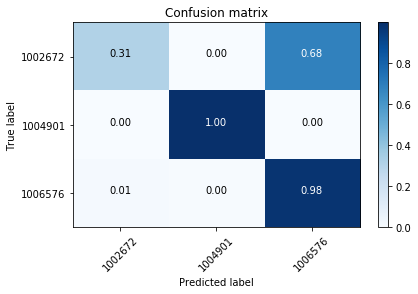

In [42]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), some_values, normalize=True)

# Lightgbm

In [ ]:
# import lightgbm as lgb
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV

# print('Start training...')
# # train
# gbm = lgb.LGBMClassifier() #num_leaves=31, learning_rate=0.05, n_estimators=20)
# %time gbm.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='l1')

# print('Start predicting...')
# # predict
# %time y_pred = gbm.predict(x_test)
# # eval
# # print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# # feature importances
# # print('Feature importances:', list(gbm.feature_importances_))

# # other scikit-learn modules
# # estimator = lgb.LGBMRegressor(num_leaves=31)

# # param_grid = {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [20, 40]}

# # gbm = GridSearchCV(estimator, param_grid)

# # gbm.fit(X_train, y_train)

# # print('Best parameters found by grid search are:', gbm.best_params_)

Start training...


In [ ]:
# accuracy_score(y_test, y_pred)

In [ ]:
# confusion_matrix(y_test, y_pred)

In [ ]:
# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)

In [8]:
# from lightgbm import LGBMClassifier
# from mlens.model_selection import Evaluator
# from mlens.metrics import rmse, make_scorer
# from scipy.stats import uniform, randint


# scorer = make_scorer(rmse)

# evl = Evaluator(scorer, n_jobs=-1, backend='multiprocessing', verbose=100)
# evl.fit(x_train, y_train, [('model', LGBMClassifier(nthread=-1))],
#          {'model':
#                   {'learning_rate': uniform(0.02,0.04),
#                    'num_leaves': randint(50, 60),
#                   'n_estimators': randint(150,200),
#                   'min_child_weight': randint(30,60)}
#          }
#       )

In [ ]:
# %time y_pred = evl.predict(x_test)

In [76]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [77]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
%time rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000018D63144F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000018D63144F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(616, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(616, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (616, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=616, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 12, 19, 16, 2, 206172, tzinfo=tzutc()), 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'session': '80fbe17cc4434eb688e083bb3a3ea874', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'80fbe17cc4434eb688e083bb3a3ea874']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 12, 19, 16, 2, 206172, tzinfo=tzutc()), 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'session': '80fbe17cc4434eb688e083bb3a3ea874', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'80fbe17cc4434eb688e083bb3a3ea874'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 12, 19, 16, 2, 206172, tzinfo=tzutc()), 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'session': '80fbe17cc4434eb688e083bb3a3ea874', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8c68f77a9eaa4ab8809daecedaed75ad', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Use the random grid to search for best hyperpa...earch model\n%time rf_random.fit(x_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-77-8187a86681d1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 18ff785d4a8, executio...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000018F76905B70, file "<ipython-input-77-8187a86681d1>", line 8>
        result = <ExecutionResult object at 18ff785d4a8, executio...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000018F76905B70, file "<ipython-input-77-8187a86681d1>", line 8>, result=<ExecutionResult object at 18ff785d4a8, executio...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000018F76905B70, file "<ipython-input-77-8187a86681d1>", line 8>
        self.user_global_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}
        self.user_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
C:\Users\Administrator\Repos\Microbiomics\<ipython-input-77-8187a86681d1> in <module>()
      3 rf = RandomForestClassifier()
      4 # Random search of parameters, using 3 fold cross validation, 
      5 # search across 100 different combinations, and use all available cores
      6 rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
      7 # Fit the random search model
----> 8 get_ipython().run_line_magic('time', 'rf_random.fit(x_train, y_train)')

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='rf_random.fit(x_train, y_train)', _stack_depth=1)
   2126             kwargs = {}
   2127             # Grab local namespace if we need it:
   2128             if getattr(fn, "needs_local_scope", False):
   2129                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2130             with self.builtin_trap:
-> 2131                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['rf_random.fit(x_train, y_train)']
        kwargs = {'local_ns': {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}}
   2132             return result
   2133 
   2134     def run_cell_magic(self, magic_name, line, cell):
   2135         """Execute the given cell magic.

...........................................................................
C:\Users\Administrator\Repos\Microbiomics\<decorator-gen-63> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='rf_random.fit(x_train, y_train)', cell=None, local_ns={'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...})

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, 'rf_random.fit(x_train, y_train)', None, {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, 'rf_random.fit(x_train, y_train)', None, {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...})
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='rf_random.fit(x_train, y_train)', cell=None, local_ns={'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...})
   1225         # time execution
   1226         wall_st = wtime()
   1227         if mode=='eval':
   1228             st = clock2()
   1229             try:
-> 1230                 out = eval(code, glob, local_ns)
        out = undefined
        code = <code object <module> at 0x0000019211076030, file "<timed eval>", line 1>
        glob = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}
        local_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Bio': <module 'Bio' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Bio\\__init__.py'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', 'import Bio\nfrom Bio import SeqIO\nimport numpy as...ver\n\nsub_data_root = data_root + "sample01split/"', "def make_features(seq, sub_seq_bank, lable):\n   ...s)\n    df['lable'] = lable    \n    return df\n    ", 'df1 = pd.read_pickle(data_root + "DNA_data1.pickle")', 'df2 = pd.read_pickle(data_root + "DNA_data2.pickle")', 'print(df1.shape)\nprint(df2.shape)\ndf = pd.concat([df1, df2]) \n\ndf.head()', 'df.shape', "with open(data_root + 'taxid.txt') as f:\n    keys = f.readlines()\nkeys = [x.strip() for x in keys] ", "some_values = keys[:10]\ndf1 = df.loc[df['lable'].isin(some_values)]", 'df1.head(10)', 'gc.collect()\ndf1.shape', "get_ipython().run_line_magic('time', 'df1 =  convert_read_to_numb(df1, 4)')", 'df1.head(10)', 'columns = list(df1.columns.values)\nprint(type(co...alues[:, :-1]\ny = df1.values[:, -1]\n# df.head(20)', '# pickle_file = data_root + "DNA_data.pickle"\n\n#...o save data to\', pickle_file, \':\', e)\n#     raise', 'x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)', '# %time gbm = xgb.XGBClassifier(max_depth=4, n_e... n_jobs=32).fit(x_train, y_train)\n# print("done")', '# %time y_pred = gbm.predict(x_test)\n# print("done")', '# accuracy_score(y_test, y_pred)', "# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)", ...], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {5:                                                 ...AGTACGGCCACGTGGTCTTCACGCTCGAACCATTGCC...   741091, 6: (78731623, 2), 9:                                                 ...CGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...  1004901, 10: (214419, 2), 12:    0    1    2    3    4    5    6    7    8    ...  0    1    1  1004901  

[10 rows x 257 columns], 35: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 37: 0.6566624691012546, 38: array([[ 447,    0,  235,    8,  159,   39,  441... 20,  396,    6,  277, 6681]],
      dtype=int64), 60: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 62: 0.6550767221678093, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, ...}
   1231             except:
   1232                 self.shell.showtraceback()
   1233                 return
   1234             end = clock2()

...........................................................................
C:\Users\Administrator\Repos\Microbiomics\<timed eval> in <module>()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=3, error_score='raise',
  ...turn_train_score='warn', scoring=None, verbose=2), X=array([[-0.64711261, -0.67223719, -0.74219387, .... -0.62177941,
        -0.61905645,  0.60391137]]), y=array(['1004901', '1017', '1017', ..., '100901', '1019', '1007676'],
      dtype=object), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = array([[-0.64711261, -0.67223719, -0.74219387, .... -0.62177941,
        -0.61905645,  0.60391137]])
        y = array(['1004901', '1017', '1017', ..., '100901', '1019', '1007676'],
      dtype=object)
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Tue Jun 12 12:36:29 2018
PID: 9936                 Python 3.6.5: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645,  0.60391137]]), array(['1004901', '1017', '1017', ..., '100901', '1019', '1007676'],
      dtype=object), {'score': <function _passthrough_scorer>}, array([     0,      1,      2, ..., 115156, 115171, 115183]), array([112744, 112746, 112763, ..., 171524, 171525, 171526]), 2, {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645,  0.60391137]]), array(['1004901', '1017', '1017', ..., '100901', '1019', '1007676'],
      dtype=object), {'score': <function _passthrough_scorer>}, array([     0,      1,      2, ..., 115156, 115171, 115183]), array([112744, 112746, 112763, ..., 171524, 171525, 171526]), 2, {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645,  0.60391137]]), y=array(['1004901', '1017', '1017', ..., '100901', '1019', '1007676'],
      dtype=object), scorer={'score': <function _passthrough_scorer>}, train=array([     0,      1,      2, ..., 115156, 115171, 115183]), test=array([112744, 112746, 112763, ..., 171524, 171525, 171526]), verbose=2, parameters={'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    487         # _score will return dict if is_multimetric is True
    488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
--> 492                                   is_multimetric)
        is_multimetric = True
    493 
    494     if verbose > 2:
    495         if is_multimetric:
    496             for scorer_name, score in test_scores.items():

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X_test=memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]), y_test=array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object), scorer={'score': <function _passthrough_scorer>}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False)
        X_test = memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]])
        y_test = array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object)
        scorer = {'score': <function _passthrough_scorer>}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X_test=memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]), y_test=array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object), scorers={'score': <function _passthrough_scorer>})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function _passthrough_scorer>
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False)
        X_test = memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]])
        y_test = array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object)
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in _passthrough_scorer(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), *args=(memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]), array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object)), **kwargs={})
    239     return scorer
    240 
    241 
    242 def _passthrough_scorer(estimator, *args, **kwargs):
    243     """Function that wraps estimator.score"""
--> 244     return estimator.score(*args, **kwargs)
        estimator.score = <bound method ClassifierMixin.score of RandomFor...e=None, verbose=0,
            warm_start=False)>
        args = (memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]), array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object))
        kwargs = {}
    245 
    246 
    247 def check_scoring(estimator, scoring=None, allow_none=False):
    248     """Determine scorer from user options.

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py in score(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]), y=array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object), sample_weight=None)
    344         score : float
    345             Mean accuracy of self.predict(X) wrt. y.
    346 
    347         """
    348         from .metrics import accuracy_score
--> 349         return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
        accuracy_score = <function accuracy_score>
        y = array(['1004901', '1017', '1017', ..., '1007676', '1007676', '1007676'],
      dtype=object)
        self.predict = <bound method ForestClassifier.predict of Random...e=None, verbose=0,
            warm_start=False)>
        X = memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]])
        sample_weight = None
    350 
    351 
    352 ###############################################################################
    353 class RegressorMixin(object):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in predict(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]]))
    533         Returns
    534         -------
    535         y : array of shape = [n_samples] or [n_samples, n_outputs]
    536             The predicted classes.
    537         """
--> 538         proba = self.predict_proba(X)
        proba = undefined
        self.predict_proba = <bound method ForestClassifier.predict_proba of ...e=None, verbose=0,
            warm_start=False)>
        X = memmap([[-0.64711261, -0.67223719, -0.74219387, ...-0.62177941,
         -0.61905645, -0.55143271]])
    539 
    540         if self.n_outputs_ == 1:
    541             return self.classes_.take(np.argmax(proba, axis=1), axis=0)
    542 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in predict_proba(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32))
    584         all_proba = [np.zeros((X.shape[0], j), dtype=np.float64)
    585                      for j in np.atleast_1d(self.n_classes_)]
    586         lock = threading.Lock()
    587         Parallel(n_jobs=n_jobs, verbose=self.verbose, backend="threading")(
    588             delayed(accumulate_prediction)(e.predict_proba, X, all_proba, lock)
--> 589             for e in self.estimators_)
        self.estimators_ = [DecisionTreeClassifier(class_weight=None, criter...         random_state=139770109, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=2092607730, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1871373720, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=827927126, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1917753714, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=105869161, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=830410173, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1292302064, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1085566734, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1575630002, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1707872905, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...          random_state=24175579, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=679395208, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=345961450, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...        random_state=1656728939, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=102556993, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=836257690, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...          random_state=50688945, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=527289821, splitter='best'), DecisionTreeClassifier(class_weight=None, criter...         random_state=602920225, splitter='best'), ...]
    590 
    591         for proba in all_proba:
    592             proba /= len(self.estimators_)
    593 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object ForestClassifier.predict_proba.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object ForestClassifier.predict_proba.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object ForestClassifier.predict_proba.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function accumulate_prediction>, (<bound method DecisionTreeClassifier.predict_pro...        random_state=106647660, splitter='best')>, array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32), [array([[0.00000000e+00, 1.24027582e+02, 0.000000...3.24675325e-03, 1.18223316e+01, 4.77850101e+01]])], <unlocked _thread.lock object>), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function accumulate_prediction>
        args = (<bound method DecisionTreeClassifier.predict_pro...        random_state=106647660, splitter='best')>, array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32), [array([[0.00000000e+00, 1.24027582e+02, 0.000000...3.24675325e-03, 1.18223316e+01, 4.77850101e+01]])], <unlocked _thread.lock object>)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in accumulate_prediction(predict=<bound method DecisionTreeClassifier.predict_pro...        random_state=106647660, splitter='best')>, X=array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32), out=[array([[0.00000000e+00, 1.24027582e+02, 0.000000...3.24675325e-03, 1.18223316e+01, 4.77850101e+01]])], lock=<unlocked _thread.lock object>)
    378 # This is a utility function for joblib's Parallel. It can't go locally in
    379 # ForestClassifier or ForestRegressor, because joblib complains that it cannot
    380 # pickle it when placed there.
    381 
    382 def accumulate_prediction(predict, X, out, lock):
--> 383     prediction = predict(X, check_input=False)
        prediction = undefined
        predict = <bound method DecisionTreeClassifier.predict_pro...        random_state=106647660, splitter='best')>
        X = array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32)
    384     with lock:
    385         if len(out) == 1:
    386             out[0] += prediction
    387         else:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py in predict_proba(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=106647660, splitter='best'), X=array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32), check_input=False)
    817             The class probabilities of the input samples. The order of the
    818             classes corresponds to that in the attribute `classes_`.
    819         """
    820         check_is_fitted(self, 'tree_')
    821         X = self._validate_X_predict(X, check_input)
--> 822         proba = self.tree_.predict(X)
        proba = undefined
        self.tree_.predict = <built-in method predict of sklearn.tree._tree.Tree object>
        X = array([[-0.6471126 , -0.67223716, -0.7421939 , ....       -0.61905646, -0.5514327 ]], dtype=float32)
    823 
    824         if self.n_outputs_ == 1:
    825             proba = proba[:, :self.n_classes_]
    826             normalizer = proba.sum(axis=1)[:, np.newaxis]

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_tree.cp36-win_amd64.pyd in sklearn.tree._tree.Tree.predict()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_tree.cp36-win_amd64.pyd in sklearn.tree._tree.Tree.predict()

MemoryError: 
___________________________________________________________________________

In [ ]:
rf_random.best_params_

In [61]:
%time y_pred = clf.predict(x_test)

Wall time: 208 ms


In [62]:
accuracy_score(y_test, y_pred)

0.6550767221678093

In [63]:
confusion_matrix(y_test, y_pred)

array([[ 421,    0,  238,   10,  177,   29,  420,    0,   56,  319],
       [   0, 4621,    0,  166,    2,    0,    7,  536,    3,    4],
       [ 149,    3,  922,   22,  213,   53,  565,    1,  132,  636],
       [   2,  130,    5, 4198,   38,    0,  244,  308,   38,  129],
       [  78,    5,  171,   81, 1450,   30,  992,    0,  115,  573],
       [  76,    0,  199,    4,  117,  205,  246,    0,   61,  348],
       [ 104,    5,  260,  292,  419,   36, 4055,   10,  277,  850],
       [   0,  630,    1,  547,   16,    0,   52, 4142,    8,   39],
       [  44,    2,  135,  154,  116,   11,  623,    3, 1428, 1252],
       [  54,    1,  194,   79,  139,   20,  378,    8,  301, 6649]],
      dtype=int64)

Normalized confusion matrix
[[2.52095808e-01 0.00000000e+00 1.42514970e-01 5.98802395e-03
  1.05988024e-01 1.73652695e-02 2.51497006e-01 0.00000000e+00
  3.35329341e-02 1.91017964e-01]
 [0.00000000e+00 8.65517887e-01 0.00000000e+00 3.10919648e-02
  3.74601985e-04 0.00000000e+00 1.31110695e-03 1.00393332e-01
  5.61902978e-04 7.49203971e-04]
 [5.52670623e-02 1.11275964e-03 3.41988131e-01 8.16023739e-03
  7.90059347e-02 1.96587537e-02 2.09569733e-01 3.70919881e-04
  4.89614243e-02 2.35905045e-01]
 [3.92772977e-04 2.55302435e-02 9.81932443e-04 8.24430479e-01
  7.46268657e-03 0.00000000e+00 4.79183032e-02 6.04870385e-02
  7.46268657e-03 2.53338570e-02]
 [2.23175966e-02 1.43061516e-03 4.89270386e-02 2.31759657e-02
  4.14878398e-01 8.58369099e-03 2.83834049e-01 0.00000000e+00
  3.29041488e-02 1.63948498e-01]
 [6.05095541e-02 0.00000000e+00 1.58439490e-01 3.18471338e-03
  9.31528662e-02 1.63216561e-01 1.95859873e-01 0.00000000e+00
  4.85668790e-02 2.77070064e-01]
 [1.64870006e-02 7.92644261e-0

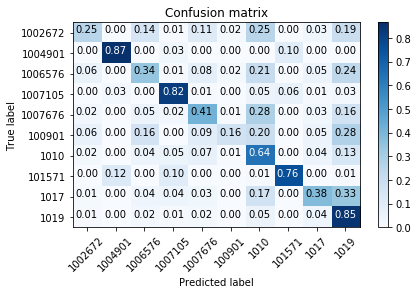

In [74]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), some_values, normalize=True)